In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install chromadb
#!pip install sentence-transformers
#!pip install langchain openai

In [2]:
import matplotlib.pyplot as plt

In [2]:
import os, sys
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import utils.chroma as chom

## Naive Retriever

In [9]:
file_path = '../data/RaptorContract.pdf'
# file_path = "../data/RobinsonAdvisory.pdf"
pdftexts = chom.pdf_reader(file_path)
pdftexts[0]

'[R&G Draft 12.__.2021] \n112923184_5  \n \nSTOCK PURCHASE AGREEMENT \nBY AND AMONG \n[BUYER], \n[TARGET COMPANY], \nTHE SELLERS LISTED ON SCHEDULE I HERETO \nAND  \nTHE SELLERS ’ REPRESENTATIVE NAMED HEREIN \nDated as of [●]  \n \n[This document is intended solely to facilitate discussions among the parties identified herein.  \nNeither this document nor such discussions are intended to create, nor will either or both be \ndeemed to create, a legally binding or enforceable offer or agreement of any type or nature, \nunless and until a definitive written agreement is executed and delivered by each of th e parties \nhereto. \n \nThis document shall be kept confidential pursuant to the terms of the Confidentiality \nAgreement entered into by the parties and, if applicable, its affiliates with respect to the subject \nmatter hereof.]'

In [10]:
from pypdf import PdfReader
from collections import namedtuple
Page = namedtuple("Page", ["id", "page_content", "metadata"])
def pdf_reader_to_document_format(file_path):
        reader = PdfReader(file_path)
        pdf_pages = []
        for page_number, page in enumerate(reader.pages):
            page_content = page.extract_text().strip()
            if page_content:
                metadata = {"page_number": page_number}  # Add any additional metadata as needed
                pdf_pages.append(Page(id=page_number, page_content=page_content, metadata=metadata))
        return pdf_pages
pdf_pages = pdf_reader_to_document_format(file_path)
pdf_pages[0]

Page(id=0, page_content='[R&G Draft 12.__.2021] \n112923184_5  \n \nSTOCK PURCHASE AGREEMENT \nBY AND AMONG \n[BUYER], \n[TARGET COMPANY], \nTHE SELLERS LISTED ON SCHEDULE I HERETO \nAND  \nTHE SELLERS ’ REPRESENTATIVE NAMED HEREIN \nDated as of [●]  \n \n[This document is intended solely to facilitate discussions among the parties identified herein.  \nNeither this document nor such discussions are intended to create, nor will either or both be \ndeemed to create, a legally binding or enforceable offer or agreement of any type or nature, \nunless and until a definitive written agreement is executed and delivered by each of th e parties \nhereto. \n \nThis document shall be kept confidential pursuant to the terms of the Confidentiality \nAgreement entered into by the parties and, if applicable, its affiliates with respect to the subject \nmatter hereof.]', metadata={'page_number': 0})

In [ ]:
token_split_texts = chom.sentence_transfomer_textsplitter(pdftexts)
token_split_texts
# # print(token_split_texts[10])
# print(f"\nTotal chunks: {len(token_split_texts)}")

In [20]:
# from langchain.embeddings.openai import OpenAIEmbeddings
# embed_model = OpenAIEmbeddings(model="text-embedding-ada-002")

# embedding_fun = []
# embedded_document = embed_model.embed_documents(character_split_texts)
# embedding_fun.append(embedded_document)

In [5]:
embedding_function = chom.embedding()
# print(embedding_function([token_split_texts[10]]))

In [16]:
import chromadb
def connect_with_chromadb(embedding_function, token_split_texts):
    chroma_client = chromadb.Client()
    chroma_collection = chroma_client.create_collection("microsoft_annual_report_2l5", embedding_function=embedding_function)

    ids = [str(i) for i in range(len(token_split_texts))]

    chroma_collection.add(ids=ids, documents=token_split_texts)
    chroma_collection.count()
    return chroma_collection

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
def chunking_RecursiveCharacterTextSplitter(pdf_doc):
        text = '\n\n'.join([page.page_content for page in pdf_doc])
        text_splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", "\n", " "],
            chunk_size=200,
            chunk_overlap=100,
            length_function=len,
            is_separator_regex=False
        )

        chunk_list = []
        for i, chunk in enumerate(text_splitter.create_documents([text])):
            metadata = {"page_number": [page.metadata["page_number"] for page in pdf_doc if page.page_content in chunk.page_content]}
            chunk_list.append(Document(id=i, page_content=chunk.page_content, metadata=metadata))

        return chunk_list

tsplit_texts = chunking_RecursiveCharacterTextSplitter(pdf_pages)

In [140]:
# tsplit_texts

In [21]:
import openai
from langchain_community.embeddings.openai import OpenAIEmbeddings
from langchain_community.vectorstores import SupabaseVectorStore
from supabase.client import create_client
from dotenv import dotenv_values

env_vars = dotenv_values('../.env')
supabase_url = env_vars.get('SUPABASE_URL')
supabase_key = env_vars.get('SUPABASE_KEY')

def fetch_stored_embedding():
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=openai.api_key)
    supabase_client = create_client(supabase_url, supabase_key)
    vector_store = SupabaseVectorStore(
        client=supabase_client,
        embedding=embeddings,
        table_name="documents",
        query_name="match_documents",
    )
    return vector_store
vector_store = fetch_stored_embedding()

# def store_to_supabase(docs: list):
#     embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=openai.api_key)
#     supabase_client = create_client(supabase_url, supabase_key)
#     vector_store = SupabaseVectorStore.from_documents(
#         docs,
#         embeddings,
#         client=supabase_client,
#         table_name="documents",
#         query_name="match_documents",
#         chunk_size=500,
#     )
#     return vector_store
# # docs = [ Document(page_content="This is a long text", metadata={"id": 1})]
# store_to_supabase(tsplit_texts)

In [47]:
supabase_client = create_client(supabase_url, supabase_key)
total_count = supabase_client.table("documents").select("*", count="exact").execute().count
print(f"Total count of embeddings in the vector store: {total_count}")

Total count of embeddings in the vector store: 2456


In [19]:
# import chromadb

# def connect_with_chromadb(embedding_function, token_split_texts):
#     chroma_client = chromadb.Client()
#     chroma_collection = chroma_client.create_collection("microsoft_annual_report_28p5", embedding_function=embedding_function)

#     # Extract the text from the Document objects
#     text_list = [doc.page_content for doc in token_split_texts]

#     ids = [str(i) for i in range(len(text_list))]

#     chroma_collection.add(ids=ids, documents=text_list)
#     chroma_collection.count()
#     return chroma_collection

# chroma_collection = connect_with_chromadb(embedding_function, tsplit_texts)

In [ ]:
chroma_collection = connect_with_chromadb(embedding_function, tsplit_texts)
# chroma_collection.count()

In [127]:
chroma_collection

def vectordb_answer_question(query, chroma_collection):
    # query = "What was the total revenue?"
    results = chroma_collection.query(query_texts=[query], n_results=chroma_collection.count())
    retrieved_documents = results['documents'][0]

    # for document in retrieved_documents:
    #     print(document)
    #     print('\n')
    return retrieved_documents


In [35]:
type(chroma_collection)

chromadb.api.models.Collection.Collection

In [20]:
from dotenv import dotenv_values
env_vars = dotenv_values('../.env')
openai.api_key = env_vars.get('OPENAI_API_KEY')
openai_client = openai.OpenAI(api_key=openai.api_key)
def openai_model_answer(query, retrieved_documents, model="gpt-3.5-turbo"):
    information = "\n\n".join([doc.page_content for doc in retrieved_documents])

    messages = [
        {"role": "system", "content": "You are an AI assistant that provides answers to questions based on the given information."},
        {"role": "user", "content": f"Question: {query}. Information: {information}"}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )

    return response.choices[0].message.content.strip()

In [24]:
query ="Is the escrow amount greater that the retention amount?"
res = vector_store.similarity_search(query)
output_answer = openai_model_answer(query=query, retrieved_documents=res)
print(output_answer)

Based on the provided information, it is stated in the Confidentiality, Non-Compete, and IP Ownership Undertaking that any Work Product created will be fully and exclusively owned by the Company, and the Advisor will not obtain any rights in the Work Product. Additionally, the Advisor will not be entitled to any compensation with respect to the Services that is not specifically agreed in writing between the Advisor and the Company. This indicates that the escrow amount is greater than the retention amount in this context.


In [51]:
res

[Document(metadata={'page_number': 2}, page_content='-  3- \n \nconstitute salary payments, and 40% of such payments shall constitute payment by the Company for \nall other Advisor statutory rights and benefits as employee of the Company throughout the Term. \nAdvisor further consents that the Compan y may offset any amounts due to him under this Section \nfrom any amounts payable to Advisor under this Agreement. Advisor shall indemnify the Company \nfor any loss or expenses incurred by the Company if it were determined that an alleged \nemployer/employee relationship existed between the Advisor and the Company.  \n \n9. Entire Agreement; No Waiver or Assignment : This Agreement together with the Exhibits, which \nare attached hereto and incorporated herein, set forth the entire Agreement between the pa rties and \nshall supersede all previous communications and agreements between the parties, either oral or \nwritten. This Agreement may be modified only by a written amendment executed

In [ ]:
# query = "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"
query = "Is the escrow amount greater than the retention amount?"
# query ="Who are the parties to the Agreement and what are their defined names?"
# query = "Is there a non-compete obligation to the Advisor?"
# query = "In which street does the Advisor live?"
retrieved_documents = vectordb_answer_question(query, chroma_collection)
# output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
# print(output_answer)

In [129]:
retrieved_documents

['Securityholder ’s Pro Rata Percentage (the “Allocation Statement ”).6  \n(b) At the Closing, Buyer shall deposit the Escrow Amount with the Escrow Agent to',
 'the Escrow Agreement or (ii) the amount, if any, by which such estimated Purchase Price paid at \nClosing in accordance with Section 2.05(a)(i) and Section 2.07(a) exceeds such re-calculated',
 'such released amounts in accordance with their Pro Rata Percentages.  From and after the \nClosing, Buyer and the Sellers ’ Representative will direct the Escrow Agent to disburse',
 'Escrow Agent shall release the Escrow Amount to Company Securityholders in accordance with \nthe Escrow Agreement or (ii) the amount, if any, by which such estimated Purchase Price paid at',
 'and (ii) the amounts, if any, from time to time payable to such Optionholder in respect \nthereof under the Escrow Agreement.',
 '(a) At Closing, Buyer will deposit the Escrow Amount in escrow on behalf of the \nSellers in accordance with the Escrow Agreement.  The 

In [68]:
import numpy as np
#cross encoder reranker
from sentence_transformers import CrossEncoder

def reranker(query, retrieved_documents):
    cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    query_text = query
    pairs = [[query_text, doc.page_content] for doc in retrieved_documents]
    
    scores = cross_encoder.predict(pairs)
    for score in scores:
        f"{score:.2f}"
    ordered_indices = np.argsort(scores)[::-1]
    for i in ordered_indices:
        f"{i+1}. {retrieved_documents[i]}"
    top_scored_docs = [retrieved_documents[i] for i in ordered_indices[:15]]

    return top_scored_docs

In [27]:
def generate_llm_response(question, ranked_docs):
        try:
            #information = "\n\n".join([doc.page_content for doc in ranked_docs])

            messages = [
                {"role": "system", "content": "You are an AI assistant that provides answers to questions based on the given information."},
                {"role": "user", "content": f"Question: {question}. Information: {ranked_docs}"}
            ]

            response = openai_client.chat.completions.create(
                model="gpt-4",
                messages=messages,
            )

            return response.choices[0].message.content.strip()
        except Exception as e:
            return f'Error: {str(e)}'  

In [ ]:
query = "In which street does the Advisor live?"
retrieved_documents = vectordb_answer_question(query, chroma_collection)

In [78]:
from openai import ChatCompletion

def get_response_stream(question, ranked_docs):
    # client = ChatCompletion()
    response_stream = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": f"Question: {question}. Information: {ranked_docs}"}],
        temperature=0,
        max_tokens=729,
        top_p=1,
        stream=True,
    )
    return response_stream

import textwrap
from IPython.display import display, clear_output, HTML


def process_streamed_responses(response_stream):
    response_text = ""
    for chunk in response_stream:
        chunk_message = chunk.choices[0].delta.content
        if chunk_message is not None:  # Check if chunk_message is not None
            response_text += chunk_message
        is_complete = chunk.choices[0].finish_reason is not None
        wrapped_text = textwrap.fill(response_text, width=80)  # Wrap text at 80 characters
        clear_output(wait=True)
        display(HTML(f"<div style='text-align: left;'><pre>{wrapped_text}</pre></div>"))
        if is_complete:
            break
    return response_text


def main(query, ranked_docs):
    stream = get_response_stream(query, ranked_docs)
    text =  process_streamed_responses(stream)
    return text


# run_async_in_notebook(main())


In [61]:

query ="Who are the parties to the Agreement and what are their defined names?"
res = vector_store.similarity_search(query)

In [67]:
res

[Document(metadata={'page_number': 2}, page_content='-  3- \n \nconstitute salary payments, and 40% of such payments shall constitute payment by the Company for \nall other Advisor statutory rights and benefits as employee of the Company throughout the Term. \nAdvisor further consents that the Compan y may offset any amounts due to him under this Section \nfrom any amounts payable to Advisor under this Agreement. Advisor shall indemnify the Company \nfor any loss or expenses incurred by the Company if it were determined that an alleged \nemployer/employee relationship existed between the Advisor and the Company.  \n \n9. Entire Agreement; No Waiver or Assignment : This Agreement together with the Exhibits, which \nare attached hereto and incorporated herein, set forth the entire Agreement between the pa rties and \nshall supersede all previous communications and agreements between the parties, either oral or \nwritten. This Agreement may be modified only by a written amendment executed

In [80]:
# query = "How much is the escrow amount?"
# from utils.reranking import CrossEncoderReranker
# top_docs = cross_encoder_reranker(query, retrieved_documents)
top_docs = reranker(query, res)
# query ="Who are the parties to the Agreement and what are their defined names?"

output_answer = main(query, top_docs)
# output_answer = generate_llm_response(query, top_docs)
print(output_answer)

The parties to the Agreement are Cloud Investments Ltd. and Mr. Jack Robinson. Their defined names are Silvan Joseph (CEO of Cloud Investments Ltd.) and Jack Robinson (Advisor).


In [113]:
len(retrieved_documents)

122

In [71]:
top_docs

['##mation of the contemplated transactions or result in a liability of the acquired companies or buyer. section 4. 06 no brokers. except as disclosed in schedule 4. 06, such seller has no liability that is or expected to be borne by any acquired company or the buyer to any broker, finder or agent with respect to the contemplated transactions, and such seller agrees to satisfy in full any liability required to be disclosed on schedule 4. 06. article v representations and warranties of the buyer. the buyer represents and warrants to the sellers that : section 5. 01 organization. the buyer is duly organized, validly existing and in good standing under the laws of the jurisdiction of its organization.',
 '......... 38 article iv individual representations and warranties of the sellers...................................................................................................................................... 38 section 4. 01 organization............................................

In [ ]:
import pandas as pd
import pprint
evaluation = pd.read_csv('../data/RaptorQA.csv')

answers = []
contexts = []
for question in evaluation['question']:
    docs = reranker(question)
    answer = chom.openai_model_answer(query=question, retrieved_documents=docs)
    pprint.pp(answer)
    answers.append(answer)
    
    context = [doc for doc in docs]
    contexts.append(context)

evaluation['answer'] = answers
evaluation['contexts'] = contexts
# evaluation.head()
evaluation.to_csv('../data/updated_raptor_crossendoderReranker_evaluation.csv', index=False)

# UMAP

In [ ]:
# !pip install umap-learn

In [ ]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

In [ ]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [ ]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 17/17 [00:10<00:00,  1.64it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

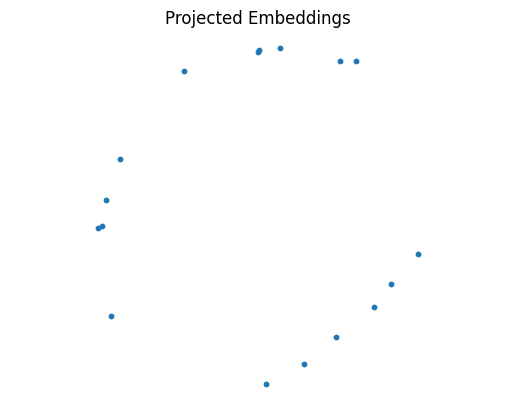

In [ ]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

# Relevancy and Distraction

In [ ]:
query = "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

providing the company a prompt written notice and subject to promptl y cooperate with the company in seeking a protective order. 3. safeguard : the advisor shall safeguard the confidential information, keep it in strict confidence and shall not disclose it to any third party without the prior written consent of the company. 4. ip : any work product, upon creation, shall be fully and exclusivel y owned by the company. the advisor, immediately upon company ’ s request, shall sign any document and / or perform any action neede d to formalize such ownership. the advisor shall not obtain any righ ts in the work product, including moral rights and / or rights for royalties or ot her consideration under any applicable law ( including section 134 of the israeli patent law – 1967 if applicable ), and shall not be entitled to any compe nsation with respect to the services, which was not specifically agreed, in writing, between the advisor and the comp any.

7. third parties : the advisor represe

In [ ]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

Sellers are responsible for breach of representations and warranties if they fail to provide prompt written notices and cooperate to seek protective orders as per agreement terms.


In [ ]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

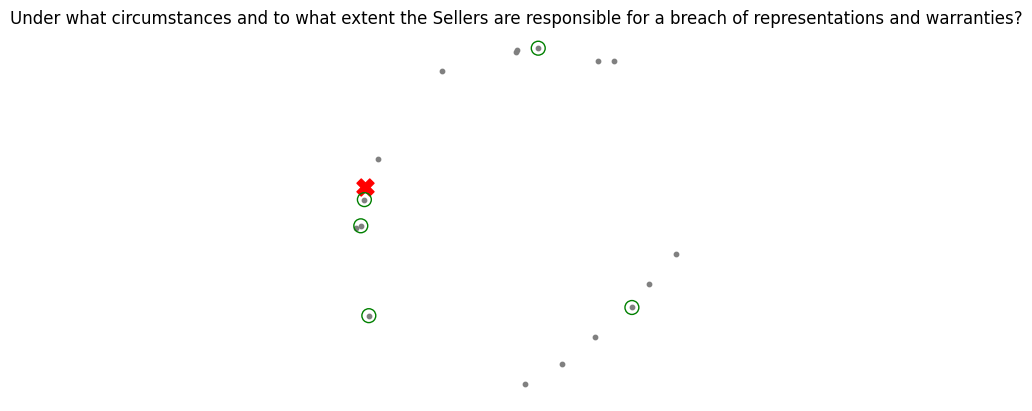

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [ ]:
query = "How much is the escrow amount in value?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

- 2 - 4. term : the term of this agreement shall commence on the effective date and shall continue until terminated in accordance with the provisions herein ( the " term " ). 5. termination : either party, at any given time, may terminate this agreement, for any reason whatsoever, with or without cause, upon fourteen ( 14 ) days ’ prior written notice. notwithstanding the above, the company may terminate this agreement immediately and without prior notice if advisor refuses or is unable to perform the services, or is in breach of any provision of this agreement. 6. compensation : 6. 1 as full and sole consideration for the services, and subject to the performance of the services, the company shall pay the advisor, against an invoice provided to the company by advisor, hourly fees at a rate of usd 9 ( nine ) per billable hour as defined below, limited to a maximum of usd 1, 500 per month ( the " fees " ). in addition, the company shall pay the advisor usd 100

this agreement may not be 

In [ ]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The value of the escrow amount is not provided in the information given.


In [ ]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

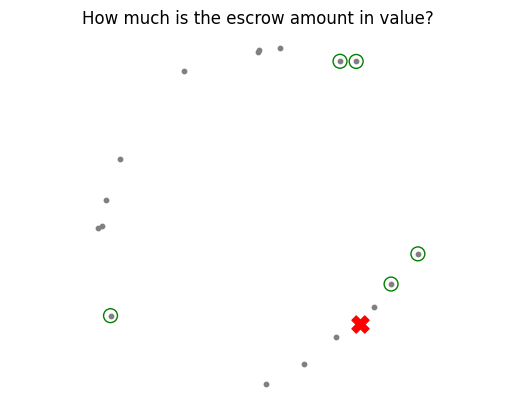

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [ ]:
query = "How much is the escrow amount?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

- 2 - 4. term : the term of this agreement shall commence on the effective date and shall continue until terminated in accordance with the provisions herein ( the " term " ). 5. termination : either party, at any given time, may terminate this agreement, for any reason whatsoever, with or without cause, upon fourteen ( 14 ) days ’ prior written notice. notwithstanding the above, the company may terminate this agreement immediately and without prior notice if advisor refuses or is unable to perform the services, or is in breach of any provision of this agreement. 6. compensation : 6. 1 as full and sole consideration for the services, and subject to the performance of the services, the company shall pay the advisor, against an invoice provided to the company by advisor, hourly fees at a rate of usd 9 ( nine ) per billable hour as defined below, limited to a maximum of usd 1, 500 per month ( the " fees " ). in addition, the company shall pay the advisor usd 100

- 3 - constitute salary pa

In [ ]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The escrow amount is not mentioned in the provided information.


In [ ]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

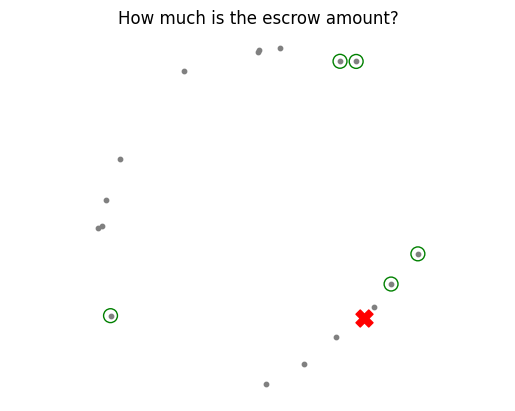

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [ ]:
query = "Are there any conditions to the closing?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

5. non - compete : during the term of engagement with the company and for a period of 12 months thereafter, advisor shall not be involved, as an employee, owner, contractor or otherwise, in any business, which competes with the company ’ s business, and shall not solicit and / or hire any employee and / or service provider of the company, without the prior written consent of the company. 6. personnel : the advisor may provide the services only directly or through employees, contractors or agents ( “ personnel ” ), which were specifically approved by the company, and have committed in writ ing to confidentiality and ownership rights towards the advisor and / or the company, in a form restrictive enough to allow advisor to comply and enforce the commitments under this undertaking ( “ authorized personnel ” ). without limiting the foregoing, the advisor is liable hereunder for any breach of this undertaking by any advisor personne l.

- 2 - 4. term : the term of this agreement shall comme

In [ ]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The conditions for closing include a non-compete clause, termination clauses, compensation details, specifics about authorized personnel, and jurisdiction rules.


In [ ]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

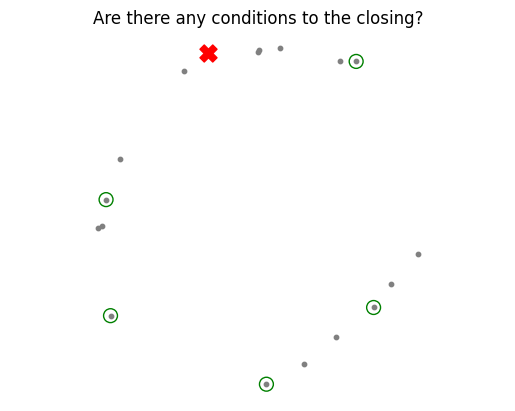

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')